# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [94]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_train = X_train.transpose(0, 3, 2, 1)
X_test = X_test.transpose(0, 3, 2, 1)
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]


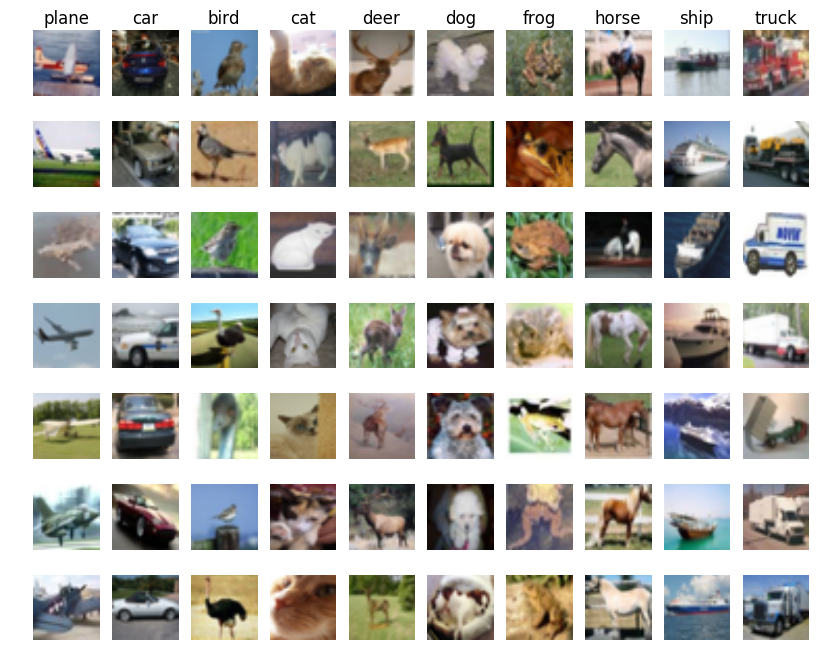

In [108]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].transpose(2, 1, 0).astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [96]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int64')
input_shape = [None,3, 32,32]
print X_train.shape

(40000, 3, 32, 32)


Так задаётся архитектура нейронки

In [110]:
input_layer = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X)

# Для вдохновления 
# - http://torch.ch/blog/2015/07/30/cifar.html
# - http://www.robots.ox.ac.uk/~vgg/research/very_deep/
#  - https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf

conv2d1 = lasagne.layers.Conv2DLayer(incoming=input_layer, num_filters=16, filter_size=(5,5), stride=2, pad=2)
maxpool2D1 = lasagne.layers.MaxPool2DLayer(incoming=conv2d1, pool_size=(2, 2))
conv2d2 = lasagne.layers.Conv2DLayer(incoming=maxpool2D1, num_filters=20, filter_size=(5, 5), pad=2)
maxpool2D2 = lasagne.layers.MaxPool2DLayer(incoming=conv2d2, pool_size=(2, 2))
conv2d3 = lasagne.layers.Conv2DLayer(incoming=maxpool2D2, num_filters=20, filter_size=(5, 5), stride=2, pad=2)
maxpool2D3 = lasagne.layers.MaxPool2DLayer(incoming=conv2d3, pool_size=(2, 2))
#dropl1 = lasagne.layers.DropoutLayer(incoming=maxpool2D2, p=0.5)
#nnet = lasagne.layers.DenseLayer(incoming=dropl1, num_units = 256, nonlinearity=lasagne.nonlinearities.rectify, name="hidden_dense_layer")
# dropl2 = lasagne.layers.DropoutLayer(incoming=dense_1, p=0.5)
# nnet = lasagne.layers.DenseLayer(incoming=dense_1, num_units = 256, nonlinearity=lasagne.nonlinearities.rectify, name="hidden_dense_layer")
nnet=maxpool2D3

print nnet.output_shape

dense_output = lasagne.layers.DenseLayer(nnet, num_units = 10, nonlinearity=softmax)

(None, 20, 1, 1)


In [111]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [112]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b, W, b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [113]:
def categorical_accuracy(predictions, targets, top_k=1):
    """Computes the categorical accuracy between predictions and targets.
    .. math:: L_i = \\mathbb{I}(t_i = \\operatorname{argmax}_c p_{i,c})
    Can be relaxed to allow matches among the top :math:`k` predictions:
    .. math::
        L_i = \\mathbb{I}(t_i \\in \\operatorname{argsort}_c (-p_{i,c})_{:k})
    Parameters
    ----------
    predictions : Theano 2D tensor
        Predictions in (0, 1), such as softmax output of a neural network,
        with data points in rows and class probabilities in columns.
    targets : Theano 2D tensor or 1D tensor
        Either a vector of int giving the correct class index per data point
        or a 2D tensor of 1 hot encoding of the correct class in the same
        layout as predictions
    top_k : int
        Regard a prediction to be correct if the target class is among the
        `top_k` largest class probabilities. For the default value of 1, a
        prediction is correct only if the target class is the most probable.
    Returns
    -------
    Theano 1D tensor
        An expression for the item-wise categorical accuracy in {0, 1}
    Notes
    -----
    This is a strictly non differential function as it includes an argmax.
    This objective function should never be used with a gradient calculation.
    It is intended as a convenience for validation and testing not training.
    To obtain the average accuracy, call :func:`theano.tensor.mean()` on the
    result, passing ``dtype=theano.config.floatX`` to compute the mean on GPU.
    """
    if targets.ndim == predictions.ndim:
        targets = theano.tensor.argmax(targets, axis=-1)
    elif targets.ndim != predictions.ndim - 1:
        raise TypeError('rank mismatch between targets and predictions')

    if top_k == 1:
        # standard categorical accuracy
        top = theano.tensor.argmax(predictions, axis=-1)
        return theano.tensor.eq(top, targets)
    else:
        # top-k accuracy
        top = theano.tensor.argsort(predictions, axis=-1)
        # (Theano cannot index with [..., -top_k:], we need to simulate that)
        top = top[[slice(None) for _ in range(top.ndim - 1)] +
                  [slice(-top_k, None)]]
        targets = theano.tensor.shape_padaxis(targets, axis=-1)
        return theano.tensor.any(theano.tensor.eq(top, targets), axis=-1)

In [114]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
accuracy = categorical_accuracy(y_predicted,target_y).mean()

In [115]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=lasagne.updates.nesterov_momentum(loss, all_weights, learning_rate=0.01, momentum=0.9))
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [116]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [119]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 4 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 10 took 27.125s
  training loss (in-iteration):		nan
  train accuracy:		9.96 %
  validation accuracy:		10.14 %
Epoch 2 of 10 took 24.741s
  training loss (in-iteration):		nan
  train accuracy:		9.96 %
  validation accuracy:		10.14 %
Epoch 3 of 10 took 26.078s
  training loss (in-iteration):		nan
  train accuracy:		9.96 %
  validation accuracy:		10.14 %
Epoch 4 of 10 took 25.504s
  training loss (in-iteration):		nan
  train accuracy:		9.96 %
  validation accuracy:		10.14 %
Epoch 5 of 10 took 25.431s
  training loss (in-iteration):		nan
  train accuracy:		9.96 %
  validation accuracy:		10.14 %
Epoch 6 of 10 took 25.152s
  training loss (in-iteration):		nan
  train accuracy:		9.96 %
  validation accuracy:		10.14 %
Epoch 7 of 10 took 25.014s
  training loss (in-iteration):		nan
  train accuracy:		9.96 %
  validation accuracy:		10.14 %
Epoch 8 of 10 took 24.747s
  training loss (in-iteration):		nan
  train accuracy:		9.96 %
  validation accuracy:		10.14 %
Epoch 9 of 10 took 24.56

In [118]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		10.00 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3